In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import re

from collections import defaultdict
from scipy.stats import ttest_ind

FPS = 60

## Load data

In [130]:
# Path to the .h5 file
#file_path = '../syllable_analysis_julia_11_vids/results.h5'
file_path = '../syllable_analysis_cohort2/results.h5'

# Initialize a dictionary to hold dfs for each Mouse ID
include_latent_state = True

# Using defaultdict in case there are multiple groups per Mouse ID
dfs = defaultdict(list)

# Regular expression pattern to extract Mouse ID
# Assumes Mouse ID is the number before 'DLC' in the group name
mouse_id_pattern = re.compile(r'_(\d+)(?:\(1\))?DLC_')

with h5py.File(file_path, 'r') as file:
    for group_name in file.keys():
        # Extract Mouse ID using regex
        match = mouse_id_pattern.search(group_name)
        if match:
            mouse_id = match.group(1)
        else:
            # Handle cases where Mouse ID is not found
            print(f"Warning: Mouse ID not found in group name '{group_name}'. Skipping this group.")
            continue  # Skip this group
        
        # Check if Mouse ID already exists in the dictionary (this would indicate an error)
        if mouse_id in dfs:
            raise ValueError(f"Error: Multiple groups found for Mouse ID '{mouse_id}' in the file. Only one group per Mouse ID is expected.")
        
        group = file[group_name]
        
        # List to hold individual DataFrames for each dataset
        df_list = []
        
        for dataset_name in group.keys():
            # Exclude 'latent_state' datasets if the flag is False
            if not include_latent_state and dataset_name.startswith('latent_state'):
                continue
            
            dataset = group[dataset_name][:]
            
            # Check if dataset is at least 1D
            if dataset.ndim == 1:
                # Convert to 2D array with one column
                dataset = dataset.reshape(-1, 1)
            
            # Create column names by appending index to dataset name
            # Example: 'centroid_0', 'centroid_1', ...
            num_cols = dataset.shape[1]
            columns = [f"{dataset_name}_{i}" for i in range(num_cols)]
            
            # Convert dataset to DataFrame
            df = pd.DataFrame(dataset, columns=columns)
            df_list.append(df)
        
        if df_list:
            # Concatenate all DataFrames horizontally (axis=1)
            concatenated_df = pd.concat(df_list, axis=1)
            # Add to the dictionary with the Mouse ID as the key
            dfs[mouse_id] = concatenated_df
        else:
            print(f"Warning: No datasets found in group '{group_name}'.")

## Prepare data

In [131]:
for df in dfs.values():
    df['timestamp'] = df.index / FPS
    df['current_minute'] = df['timestamp'] / 60

In [132]:
#mouse_info = pd.read_csv('../syllable_analysis_julia_11_vids/syllables_mouseCoh1_info.csv', index_col=0)
mouse_info = pd.read_csv('../syllable_analysis_cohort2/syllables_mouseCoh2_info.csv', index_col=0)

## Split by injection

In [133]:
import numpy as np
import pandas as pd
from collections import defaultdict

def bin_df_by_injection_sliding_window_signed(df, mouse_id, window_size, stride):
    """
    Bins the dataframe using a sliding window approach separately for pre-injection and post-injection periods,
    assigning negative bin numbers to pre-injection windows and positive to post-injection windows.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - mouse_id (int or str): The ID of the mouse.
    - window_size (int): Size of the sliding window in minutes.
    - stride (int): Stride length for the sliding window in minutes.

    Returns:
    - dict: A dictionary with bin labels as keys and binned dataframes as values.
    """
    # Retrieve injection times from mouse_info DataFrame
    injection_times = mouse_info.loc[mouse_id][['PreInjStart', 'PreInjEnd', 'PostInjStart', 'PostInjEnd']].to_list()
    pre_inj_start, pre_inj_end, post_inj_start, post_inj_end = injection_times

    # Initialize the dictionary to store binned dataframes
    binned_dfs = {}

    # Initialize bin counters
    bin_counter_pre = -1  # Start from -1 for pre-injection bins
    bin_counter_post = 1  # Start from 1 for post-injection bins

    ### Binning Pre-Injection Data ###
    current_start = pre_inj_start
    current_end = current_start + window_size

    while current_end <= pre_inj_end:
        # Define the window
        window_df = df[(df['current_minute'] >= current_start) & (df['current_minute'] < current_end)]
        bin_label = f'bin_{bin_counter_pre}'
        binned_dfs[bin_label] = window_df

        # Update counters and window positions
        bin_counter_pre -= 1
        current_start += stride
        current_end = current_start + window_size

    ### Binning Post-Injection Data ###
    current_start = post_inj_start
    current_end = current_start + window_size

    while current_end <= post_inj_end:
        # Define the window
        window_df = df[(df['current_minute'] >= current_start) & (df['current_minute'] < current_end)]
        bin_label = f'bin_{bin_counter_post}'
        binned_dfs[bin_label] = window_df

        # Update counters and window positions
        bin_counter_post += 1
        current_start += stride
        current_end = current_start + window_size

    return binned_dfs


In [134]:
# Initialize a defaultdict to store binned dataframes
all_centroids = defaultdict(list)
window_size = 5
stride = 2

for mouse_id, df in dfs.items():
    # Apply the binning function
    binned_dfs = bin_df_by_injection_sliding_window_signed(df, int(mouse_id), window_size, stride)
    
    # Get genotype information
    genotype = mouse_info.loc[int(mouse_id)]['Genotype']  # Adjust column name as needed
    
    for bin_label, bin_df in binned_dfs.items():
        bin_number = int(bin_label.split('_')[1])
        
        # Select columns that start with 'latent'
        latent_cols = [col for col in bin_df.columns if col.startswith('latent')]
        
        # Check if there are latent columns
        if latent_cols:
            # Optionally sort the columns to maintain consistent order
            latent_cols.sort()
            # Compute the mean of latent columns
            latent_mean = bin_df[latent_cols].mean().values
            all_centroids[(bin_number, genotype)].append(latent_mean)
        else:
            # Handle bins without latent columns if necessary
            print(f"No latent columns in bin {bin_label} for mouse {mouse_id}")
            continue  # Skip this bin

# 4 laten states
all_centroids = {k: np.vstack(v)[:, :4] for k, v in all_centroids.items()}

# all laten states
# all_centroids = {k: np.vstack(v) for k, v in all_centroids.items()}

In [135]:
for k, v in all_centroids.items():
    print(k, v.shape)

(-1, 'Het') (8, 4)
(-2, 'Het') (8, 4)
(-3, 'Het') (8, 4)
(-4, 'Het') (8, 4)
(-5, 'Het') (8, 4)
(-6, 'Het') (8, 4)
(-7, 'Het') (8, 4)
(-8, 'Het') (8, 4)
(-9, 'Het') (8, 4)
(-10, 'Het') (8, 4)
(-11, 'Het') (8, 4)
(-12, 'Het') (8, 4)
(-13, 'Het') (8, 4)
(-14, 'Het') (8, 4)
(-15, 'Het') (8, 4)
(-16, 'Het') (8, 4)
(-17, 'Het') (8, 4)
(-18, 'Het') (8, 4)
(-19, 'Het') (8, 4)
(-20, 'Het') (7, 4)
(1, 'Het') (8, 4)
(2, 'Het') (8, 4)
(3, 'Het') (8, 4)
(4, 'Het') (8, 4)
(5, 'Het') (8, 4)
(6, 'Het') (8, 4)
(7, 'Het') (8, 4)
(8, 'Het') (8, 4)
(9, 'Het') (8, 4)
(10, 'Het') (8, 4)
(11, 'Het') (8, 4)
(12, 'Het') (8, 4)
(13, 'Het') (8, 4)
(14, 'Het') (8, 4)
(15, 'Het') (8, 4)
(16, 'Het') (8, 4)
(17, 'Het') (8, 4)
(18, 'Het') (8, 4)
(19, 'Het') (8, 4)
(20, 'Het') (8, 4)
(21, 'Het') (8, 4)
(22, 'Het') (8, 4)
(23, 'Het') (8, 4)
(24, 'Het') (8, 4)
(25, 'Het') (8, 4)
(26, 'Het') (8, 4)
(27, 'Het') (8, 4)
(28, 'Het') (8, 4)
(29, 'Het') (8, 4)
(30, 'Het') (8, 4)
(31, 'Het') (8, 4)
(32, 'Het') (8, 4)
(33, 'Het'

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap  # Ensure UMAP is installed: pip install umap-learn
from matplotlib.collections import LineCollection  # For multi-colored trajectory lines


In [137]:
def prepare_data(all_centroids, genotypes=['WT', 'Het'], use_group_centroid=True):
    """
    Organizes the data by genotype and bin number. Optionally computes group centroids.

    Parameters:
        all_centroids (dict): Dictionary with keys as (bin_number, genotype) and values as latent vectors.
        genotypes (list): List of genotype labels to include.
        use_group_centroid (bool): Whether to compute and use group centroids.

    Returns:
        Tuple containing:
            - data_array (np.ndarray): Array of latent vectors.
            - labels (list): Corresponding genotype labels.
            - times (list): Corresponding bin numbers (time points).
    """
    data_by_genotype_bin = {genotype: {} for genotype in genotypes}

    # Organize data
    for (bin_number, genotype), value in all_centroids.items():
        if genotype in genotypes:
            data_by_genotype_bin[genotype].setdefault(bin_number, []).append(value)

    data_list = []
    labels = []
    times = []

    if use_group_centroid:
        # Compute centroid per group
        for genotype in genotypes:
            for bin_number in sorted(data_by_genotype_bin[genotype].keys()):
                values = data_by_genotype_bin[genotype][bin_number]
                # Stack all values and compute the centroid
                try:
                    stacked_values = np.vstack(values)
                    centroid = stacked_values.mean(axis=0)
                    data_list.append(centroid)
                    labels.append(genotype)
                    times.append(bin_number)
                except ValueError:
                    print(f"Skipping genotype '{genotype}' at bin {bin_number} due to insufficient data.")
    else:
        # Use individual data points
        for genotype in genotypes:
            for bin_number in sorted(data_by_genotype_bin[genotype].keys()):
                values = data_by_genotype_bin[genotype][bin_number]
                for value in values:
                    if value.ndim == 2:
                        # Multiple samples in value
                        for row in value:
                            data_list.append(row)
                            labels.append(genotype)
                            times.append(bin_number)
                    else:
                        # Single sample
                        data_list.append(value)
                        labels.append(genotype)
                        times.append(bin_number)

    if not data_list:
        raise ValueError("No data found. Please check 'all_centroids' and 'genotypes'.")

    data_array = np.vstack(data_list)
    return data_array, labels, times


In [138]:
def perform_dimensionality_reduction(data_array, projection_method='tsne', random_state=42, **kwargs):
    """
    Reduces data dimensionality using the specified projection method.

    Parameters:
        data_array (np.ndarray): Standardized data array.
        projection_method (str): Projection method to use ('tsne', 'pca', 'umap').
        random_state (int): Seed for reproducibility.
        **kwargs: Additional parameters for the projection methods.

    Returns:
        np.ndarray: 2D array after dimensionality reduction.
    """
    method = projection_method.lower()
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, **kwargs)
        reduced_data = reducer.fit_transform(data_array)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=random_state, **kwargs)
        reduced_data = reducer.fit_transform(data_array)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=random_state, **kwargs)
        reduced_data = reducer.fit_transform(data_array)
    else:
        raise ValueError("Invalid projection method. Choose 'tsne', 'pca', or 'umap'.")
    return reduced_data


In [139]:
def map_time_to_colors(scaled_times, cmap_name='seismic', vcenter=0, vmin=-60, vmax=90):
    """
    Maps scaled time points to colors using a diverging colormap centered at vcenter.

    Parameters:
        scaled_times (list): List of scaled bin numbers representing time points.
        cmap_name (str): Name of the matplotlib colormap to use.
        vcenter (int): The central value for the diverging colormap.
        vmin (int): The minimum value for the colorbar axis.
        vmax (int): The maximum value for the colorbar axis.

    Returns:
        Tuple containing:
            - colors (list): List of RGBA color tuples.
            - sm (ScalarMappable): ScalarMappable object for the colorbar.
    """
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    # Handle Matplotlib versions
    if hasattr(cm, 'colormaps'):
        cmap = cm.colormaps.get(cmap_name)
        if cmap is None:
            raise ValueError(f"Colormap '{cmap_name}' not found.")
    else:
        cmap = cm.get_cmap(cmap_name)
    colors = [cmap(norm(t)) for t in scaled_times]
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    return colors, sm


In [140]:
def plot_trajectories(reduced_data, labels, scaled_times, colors, genotypes=['WT', 'Het'],
                     markers={'WT': 'o', 'Het': '^'}, title='Trajectories',
                     xlabel='Dimension 1', ylabel='Dimension 2', sm=None,
                     cmap_label='Time (bin number)', smoothing_sigma=1.0):
    """
    Plots the trajectories of genotypes over time in reduced 2D space.
    Both trajectory lines and scatter points are colored based on scaled time.

    Parameters:
        reduced_data (np.ndarray): 2D data after dimensionality reduction.
        labels (list): List of genotype labels corresponding to each data point.
        scaled_times (list): List of scaled bin numbers representing time points.
        colors (list): List of RGBA color tuples corresponding to each data point.
        genotypes (list): List of genotype labels to include.
        markers (dict): Dictionary mapping genotypes to matplotlib markers.
        title (str): Plot title.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        sm (ScalarMappable): ScalarMappable object for the colorbar.
        cmap_label (str): Label for the colorbar.
        smoothing_sigma (float): Sigma for Gaussian smoothing of trajectories.
    """
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)

    for genotype in genotypes:
        # Get indices for the current genotype
        idx = [i for i, label in enumerate(labels) if label == genotype]
        if not idx:
            print(f"No data points found for genotype '{genotype}'. Skipping.")
            continue
        # Sort indices by scaled time to ensure correct trajectory
        idx_sorted = sorted(idx, key=lambda i: scaled_times[i])
        x = reduced_data[idx_sorted, 0]
        y = reduced_data[idx_sorted, 1]
        c = [colors[i] for i in idx_sorted]

        if len(x) < 2:
            print(f"Not enough data points for genotype '{genotype}' to plot trajectories.")
            continue

        # Smooth the trajectories
        x_smooth = gaussian_filter1d(x, sigma=smoothing_sigma)
        y_smooth = gaussian_filter1d(y, sigma=smoothing_sigma)

        # Create segments for LineCollection
        segments = []
        segment_colors = []
        for i in range(len(x_smooth) - 1):
            seg = [(x_smooth[i], y_smooth[i]), (x_smooth[i + 1], y_smooth[i + 1])]
            segments.append(seg)
            # Assign the color of the starting point to the segment
            segment_colors.append(c[i])

        # Create a LineCollection with the segments and their corresponding colors
        lc = LineCollection(segments, colors=segment_colors, linewidths=2, alpha=0.7)
        ax.add_collection(lc)

        # Scatter points using smoothed coordinates
        sc = ax.scatter(
            x_smooth, y_smooth,
            c=c,
            marker=markers.get(genotype, 'o'),
            edgecolor='k',
            s=100,
            label=genotype
        )

    if sm:
        # Add colorbar
        cbar = plt.colorbar(sm, ax=ax, extend='both')
        cbar.set_label(cmap_label, rotation=270, labelpad=15)
        # Optionally set specific ticks
        cbar.set_ticks([-60, -30, 0, 30, 60, 90])

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title='Genotype')
    plt.tight_layout()
    plt.show()


In [141]:
def visualize_genotype_trajectories(all_centroids, genotypes=['WT', 'Het'],
                                    use_group_centroid=True, projection_method='tsne',
                                    projection_kwargs={}, cmap_name='seismic', vcenter=0,
                                    title_suffix='', smoothing_sigma=1.0):
    """
    Visualizes genotype trajectories over time using dimensionality reduction.
    Bin numbers are scaled:
        - Negative bins: [min_bin_number, 0] -> [-60, 0]
        - Positive bins: [0, max_bin_number] -> [0, 90]

    Parameters:
        all_centroids (dict): Dictionary with keys as (bin_number, genotype) and values as latent vectors.
        genotypes (list): List of genotype labels to include.
        use_group_centroid (bool): Whether to compute and plot group centroids.
        projection_method (str): Dimensionality reduction method ('tsne', 'pca', 'umap').
        projection_kwargs (dict): Additional keyword arguments for the projection method.
        cmap_name (str): Name of the matplotlib colormap to use.
        vcenter (int): The central value for the diverging colormap.
        title_suffix (str): Additional string to append to the plot title.
        smoothing_sigma (float): Sigma for Gaussian smoothing of trajectories.
    """
    try:
        # Step 1: Prepare Data
        data_array, labels, times = prepare_data(
            all_centroids=all_centroids,
            genotypes=genotypes,
            use_group_centroid=use_group_centroid
        )
    except ValueError as e:
        print(f"Data Preparation Error: {e}")
        return

    # Step 2: Standardize Data
    scaler = StandardScaler()
    data_array_scaled = scaler.fit_transform(data_array)

    # Step 3: Dimensionality Reduction
    try:
        reduced_data = perform_dimensionality_reduction(
            data_array=data_array_scaled,
            projection_method=projection_method,
            random_state=42,
            **projection_kwargs
        )
    except ValueError as e:
        print(f"Dimensionality Reduction Error: {e}")
        return

    # Step 4: Scale Bin Numbers
    min_bin = min(times)
    max_bin = max(times)

    scaled_times = []
    for t in times:
        if t < 0:
            # Scale negative bin numbers from [min_bin, 0] to [-60, 0]
            scaled_t = t * 60 / abs(min_bin) if min_bin != 0 else 0
        else:
            # Scale positive bin numbers from [0, max_bin] to [0, 90]
            scaled_t = t * 90 / max_bin if max_bin != 0 else 0
        scaled_times.append(scaled_t)

    # Step 5: Map Scaled Time to Colors
    try:
        colors, sm = map_time_to_colors(
            scaled_times=scaled_times,
            cmap_name=cmap_name,
            vcenter=vcenter,
            vmin=-60,
            vmax=90
        )
    except ValueError as e:
        print(f"Color Mapping Error: {e}")
        return

    # Step 6: Prepare Plot Title
    title = f"{projection_method.upper()} Trajectories of Genotypes Over Time"
    if use_group_centroid:
        title += " (Group Centroids)"
    if title_suffix:
        title += f" {title_suffix}"

    # Step 7: Plot Trajectories
    plot_trajectories(
        reduced_data=reduced_data,
        labels=labels,
        scaled_times=scaled_times,
        colors=colors,
        genotypes=genotypes,
        markers={'WT': 'o', 'Het': '^'},
        title=title,
        xlabel=f"{projection_method.upper()} Dimension 1",
        ylabel=f"{projection_method.upper()} Dimension 2",
        sm=sm,
        cmap_label='Time (bin number)',
        smoothing_sigma=smoothing_sigma
    )


/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_11535/1443151052.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


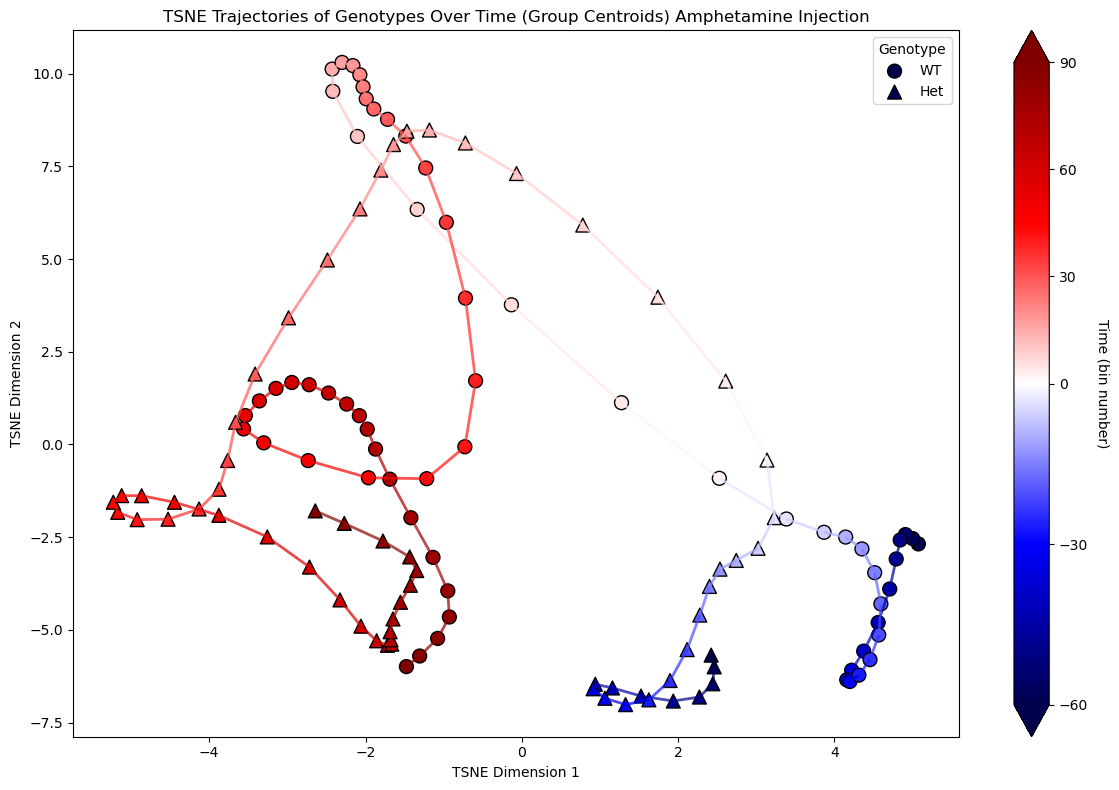

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_11535/1443151052.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


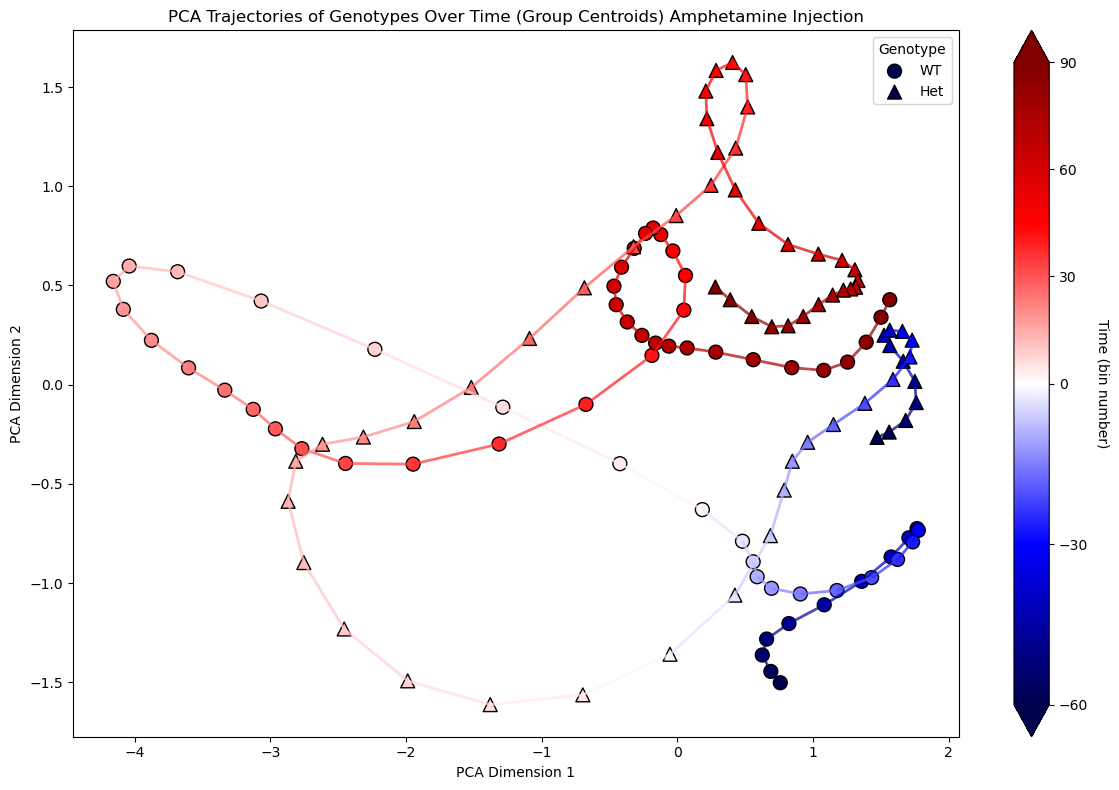

/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_11535/1443151052.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


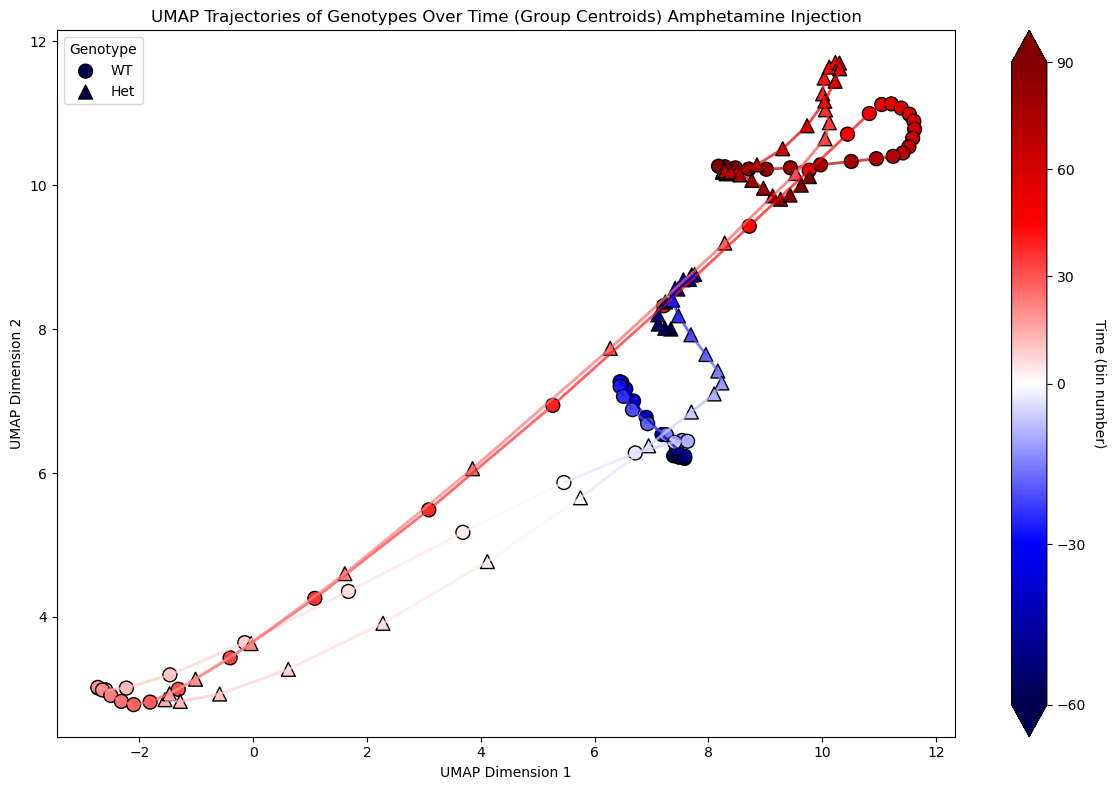

In [142]:
for projection_method in ['tsne', 'pca', 'umap']:
    # Assuming all_centroids is already defined
    visualize_genotype_trajectories(
        all_centroids=all_centroids,
        genotypes=['WT', 'Het'],                # Specify the genotypes you want to visualize
        use_group_centroid=True,                # Set to False to plot individual data points
        projection_method=projection_method,                # Choose from 'tsne', 'pca', 'umap'
        #projection_kwargs={'perplexity': 30, 'learning_rate': 200},  # Additional parameters for the projection
        cmap_name='seismic',                     # Colormap for time
        vcenter=0,                               # Central value for the colormap
        title_suffix='Amphetamine Injection',    # Optional suffix for the plot title
        smoothing_sigma=2.0                      # Smoothing parameter for trajectories
    )